In [ ]:
import warnings
import time
from collections import defaultdict

import numpy as np
import pandas as pd
import scipy.stats as sps

from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_california_housing

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.utils import shuffle

plt.rcParams['axes.facecolor'] = 'lightgrey'
sns.set(palette='Set2', font_scale=1.6)

warnings.filterwarnings("ignore")

#### 1.

Повторим исследование градиентного бустинга из `sklearn`. Сравним полученные результаты со случайным лесом.

Вкратце опишем:
1. Посмотрим, как меняется качество модели в зависимости от значений гиперпараметров. Гиперпараметры:
    * количество деревьев (`n_estimators`) [от 1 до 400];
    * максимальная глубина дерева (`max_depth`) [от 3 до 15];
    * скорость обучения (`learning_rate`), поясните также смысл этого параметра.
2. Запустим модель три раза с параметрами по-умолчанию. Объясните результаты.
3. Подберем оптимальные гиперпараметры, рассмотренные в первом пункте и зафиксируем их.
4. Исследуем зависимость метрики от количества признаков, по которым происходит разбиение в вершине дерева.

In [ ]:
housing = fetch_california_housing()
X, y = housing.data, housing.target

In [ ]:
X.shape

(20640, 8)

Разобьём данные на обучающую выборку и на валидацию, выделив на валидацию 25% данных.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=17
)

Посмотрим, как изменяется качество предсказаний градиентного бустинга в зависимости от выбранных параметров. Для этого построим графики зависимости MSE на тестовой выборке от количества деревьев и от максимальной глубины дерева.

**Построение зависимости MSE от количества деревьев**

Вспомогательная функция

In [ ]:
def plot_dependence_test(param_grid, test_values, param_label,
                         metrics_label, title):
    '''
    Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на валидационной выборке.

    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) test_values - значения метрики на валидационной выборке,
    3) param_label - названия параметра,
    4) metrics_label - название метрики,
    5) title - заголовок для графика.
    '''

    plt.figure(figsize=(12, 6))
    plt.plot(param_grid, test_values, label='тестовая выборка', linewidth=4)

    plt.xlabel(param_label)
    plt.ylabel(metrics_label)
    plt.legend()
    plt.title(title)
    plt.show()

Вычисления и построение графика

In [ ]:
mse_values = []
n_estimators_grid = range(1, 401)
regressor = GradientBoostingRegressor(
    n_estimators=max(list(n_estimators_grid)), random_state=42
)
regressor.fit(X_train, y_train)
staged_predictions = regressor.staged_predict(X_test)

mse_values = [
    mse(y_true=y_test, y_pred=prediction)
    for prediction in staged_predictions
]

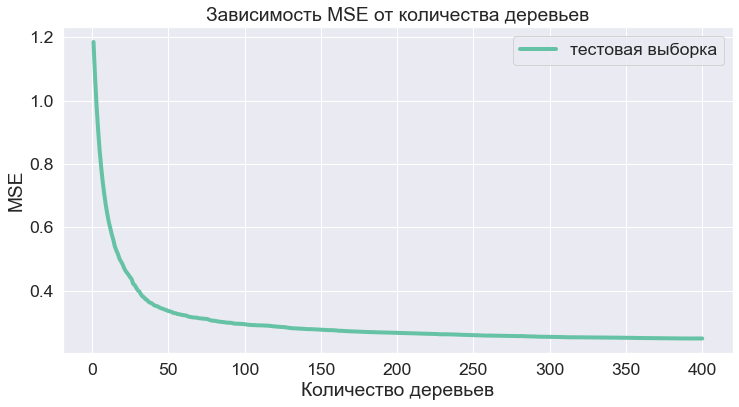

In [ ]:
plot_dependence_test(n_estimators_grid, mse_values,
                     'Количество деревьев', 'MSE',
                     'Зависимость MSE от количества деревьев')

Как и при использовании случайного леса, ошибка на тестовой выборке монотонно убывает. Но если в лесе при `n_estimators`, близком к 100, MSE практически переставала уменьшаться, то в градиентном бустинге мы видим более-менее значительные изменения вплоть до `n_estimators=350`.

**Построение зависимости MSE от максимальной глубины**

In [ ]:
mse_values = []

for max_depth in tqdm(range(3, 16)):
    regressor = GradientBoostingRegressor(
        max_depth=max_depth, n_estimators=300, random_state=42
    )
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(y_true=y_test, y_pred=predictions))

  0%|          | 0/13 [00:00<?, ?it/s]

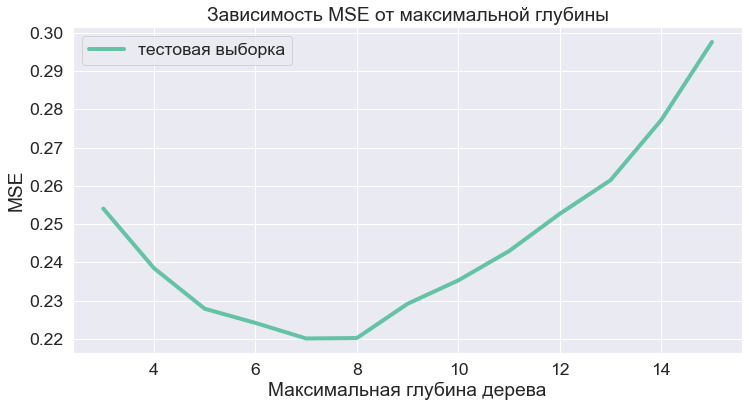

In [ ]:
plot_dependence_test(np.arange(3, 16), mse_values,
                     'Максимальная глубина дерева', 'MSE',
                     'Зависимость MSE от максимальной глубины')

Посмотрим, что будет происходить при меньших значениях `n_estimators`.

In [ ]:
mse_values = []

for max_depth in tqdm(range(3, 16)):
    regressor = GradientBoostingRegressor(
        max_depth=max_depth, n_estimators=50, random_state=42
    )
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(y_true=y_test, y_pred=predictions))

  0%|          | 0/13 [00:00<?, ?it/s]

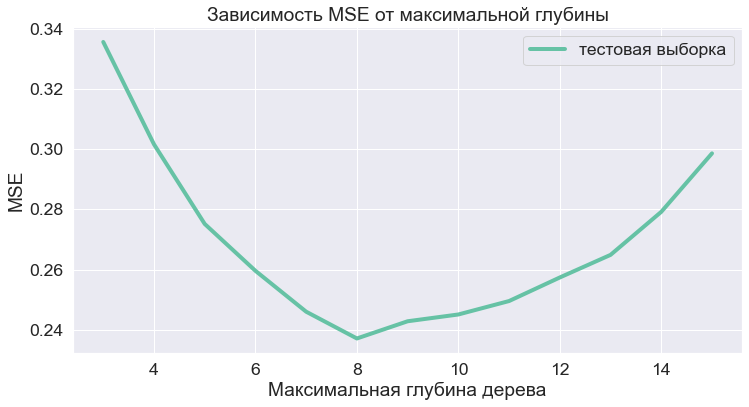

In [ ]:
plot_dependence_test(np.arange(3, 16), mse_values,
                     'Максимальная глубина дерева', 'MSE',
                     'Зависимость MSE от максимальной глубины')

Как мы видим, в отличие от случайного леса, при использовании градиентного бустинга стоит ограничивать глубину дерева, поскольку на каждой итерации бустинг уменьшает смещение (bias) итоговой модели, а не дисперсию.

**Построение зависимости MSE от значения `learning rate`**

In [ ]:
mse_values = []

for lr in tqdm(np.linspace(0.05, 0.7, 200)):
    regressor = GradientBoostingRegressor(
        learning_rate=lr, n_estimators=200, random_state=42
    )
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    mse_values.append(mse(y_true=y_test, y_pred=predictions))

  0%|          | 0/200 [00:00<?, ?it/s]

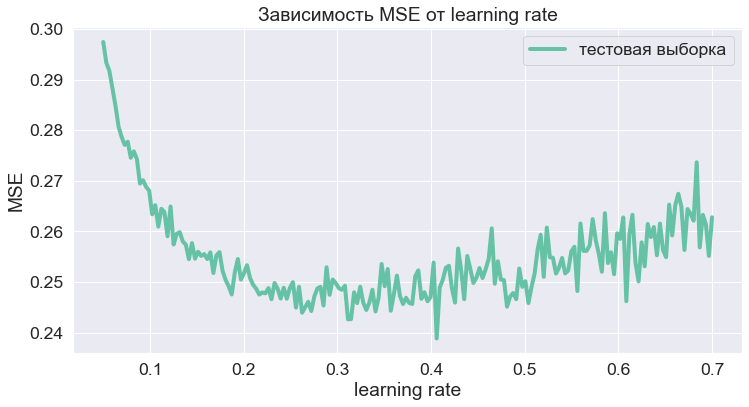

In [ ]:
plot_dependence_test(np.linspace(0.05, 0.7, 200), mse_values,
                     'learning rate', 'MSE',
                     'Зависимость MSE от learning rate')

Оптимальное значение `learning rate` близко к $0.3$.

**Вывод.**

По первому графику можно сделать вывод, что с возрастанием числа использованных деревьев, MSE снижается. Но при достаточно больших значениях `n_estimators` значение MSE практически перестаёт меняться. Здесь получается похожая ситуация, что и при использовании случайного леса. Однако "пороговое" значение `n_estimators` выше.

С параметром `max_depth` ситуация не такая, как при использовании случайного леса. Существует пороговое значение `max_depth`, выше которого модель имеет слишком высокую дисперсию и потому MSE повышается. Отсюда можно сделать предположение, что градиентный бустинг имеет более высокую дисперсию, чем случайный лес, но более низкое смещение.

Параметр `learning_rate` стоит подбирать аккуратно. Надо сделать его достаточно большим, чтобы градиентный бустинг быстро сходился и не застревал в точках, близких к локальным минимумам. При этом, он должен быть и не слишком большим, чтобы бустинг не проскакивал локальные минимумы и не расходился.

Обучим градиентный бустинг со значениями гиперпараметров по умолчанию и выведите mse на тестовой выборке. Проведем эксперимент три раза.

In [ ]:
for iteration in range(3):
    regressor = GradientBoostingRegressor(n_estimators=100)
    regressor.fit(X_train, y_train)
    predictions = regressor.predict(X_test)
    print('MSE = {:.5f}'.format(mse(y_true=y_test, y_pred=predictions)))

MSE = 0.29395
MSE = 0.29392
MSE = 0.29392


Объясним почему результаты почти не отличаются.

Результаты слабо отличаются, потому что единственный источник случайности здесь &mdash; случайная перестановка признаков в цикле для разбиения вершины. Если при разбиении вершины существуют два разделяющихся признака, которые дают одинаковое значение критерия информативности, то из них выбирается тот, что первым перебирается в цикле.

**Подбор гиперпараметров градиентного бустинга**

Было бы неплохо определиться с тем, какой шаг обучения нужно использовать и какой максимальной глубины они будут. Подберем оптимальные значения `max_depth` и `learning_rate` с помощью поиска по сетке с кросс-валидацией. Количество деревьев зафиксируем.

In [ ]:
n_estimators = 200

In [ ]:
gb_gridsearch = RandomizedSearchCV(
    estimator=GradientBoostingRegressor(n_estimators=n_estimators, random_state=42),
    param_distributions={
        'max_depth': np.arange(3, 30),
        'learning_rate': np.linspace(0.05, 0.5, 300)
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-2,  # кол-во параллельных процессов
    n_iter=50,  # кол-во итераций случайного выбора гиперпараметров
    random_state=42,  # seed для фиксирования случайности
)

In [ ]:
gb_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(n_estimators=200,
                                                       random_state=42),
                   n_iter=50, n_jobs=-2,
                   param_distributions={'learning_rate': array([0.05      , 0.05150502, 0.05301003, 0.05451505, 0.05602007,
       0.05752508, 0.0590301 , 0.06053512, 0.06204013, 0.06354515,
       0.06505017, 0.06655518, 0.0680602 , 0.06956522, 0.07107023,
       0.07257525, 0.07408027, 0.07558528, 0....
       0.4638796 , 0.46538462, 0.46688963, 0.46839465, 0.46989967,
       0.47140468, 0.4729097 , 0.47441472, 0.47591973, 0.47742475,
       0.47892977, 0.48043478, 0.4819398 , 0.48344482, 0.48494983,
       0.48645485, 0.48795987, 0.48946488, 0.4909699 , 0.49247492,
       0.49397993, 0.49548495, 0.49698997, 0.49849498, 0.5       ]),
                                        'max_depth': array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19,
       20, 21, 2

Выведем найденные оптимальные параметры.

In [ ]:
print(gb_gridsearch.best_params_)

{'max_depth': 6, 'learning_rate': 0.10418060200668897}


Зафиксируем эти оптимальные значения параметров и будем их использовать в дальнейшем.

In [ ]:
max_depth = gb_gridsearch.best_params_['max_depth']
learning_rate = gb_gridsearch.best_params_['learning_rate']

Оценим качество предсказаний обученного градиентного бустинга.

In [ ]:
predictions = gb_gridsearch.best_estimator_.predict(X_test)
print('MSE = {:.5f}'.format(mse(y_true=y_test, y_pred=predictions)))

MSE = 0.22556


**Зависимость MSE от количества признаков**

Исследуем зависимость метрики MSE от количества признаков, по которым происходит разбиение в вершине дерева. Поскольку количество признаков в датасете не очень большое (их 8), то можно перебрать все возможные варианты количества признаков, использующихся при разбиении вершин.

In [ ]:
mse_train_values = []
mse_test_values = []

for n_features in tqdm(range(1, 9)):
    rf_regressor = GradientBoostingRegressor(
        max_depth=max_depth, n_estimators=n_estimators,
        learning_rate=learning_rate, max_features=n_features,
        random_state=42
    )
    rf_regressor.fit(X_train, y_train)
    current_train_mse = mse(y_true=y_train, y_pred=rf_regressor.predict(X_train))
    current_test_mse = mse(y_true=y_test, y_pred=rf_regressor.predict(X_test))
    print('n_features: {}, train_mse: {:.5f}, test_mse: {:.5f}'.format(
        n_features, current_train_mse, current_test_mse
    ))
    mse_train_values.append(current_train_mse)
    mse_test_values.append(current_test_mse)

  0%|          | 0/8 [00:00<?, ?it/s]

n_features: 1, train_mse: 0.12310, test_mse: 0.25621
n_features: 2, train_mse: 0.09763, test_mse: 0.23658
n_features: 3, train_mse: 0.08854, test_mse: 0.22702
n_features: 4, train_mse: 0.08706, test_mse: 0.22894
n_features: 5, train_mse: 0.08500, test_mse: 0.23005
n_features: 6, train_mse: 0.08380, test_mse: 0.22596
n_features: 7, train_mse: 0.08061, test_mse: 0.23020
n_features: 8, train_mse: 0.08195, test_mse: 0.22556


Построим график зависимости метрики mse на `test` и `train` от числа признаков, использующихся при разбиении каждой вершины.

In [ ]:
def plot_dependence(param_grid, train_values, test_values,
                    param_label='', metrics_label='', title='',
                    train_label='обучающая выборка',
                    test_label='тестовая выборка',
                    create_figure=True):
    '''
    Функция для построения графиков зависимости целевой метрики
    от некоторого параметра модели на обучающей и на валидационной
    выборке.

    Параметры.
    1) param_grid - значения исследуемого параметра,
    2) train_values - значения метрики на обучающей выборке,
    3) test_values - значения метрики на валидационной выборке,
    4) param_label - названия параметра,
    5) metrics_label - название метрики,
    6) title - заголовок для графика,
    7) create_figure - флаг, устанавливающий нужно ли создавать
    новую фигуру для графика.
    '''

    if create_figure:
        plt.figure(figsize=(12, 6))
    plt.plot(param_grid, train_values, label=train_label, linewidth=3)
    plt.plot(param_grid, test_values, label=test_label, linewidth=3)

    plt.legend()
    if create_figure:
        plt.xlabel(param_label)
        plt.ylabel(metrics_label)
        plt.title(title, fontsize=20)

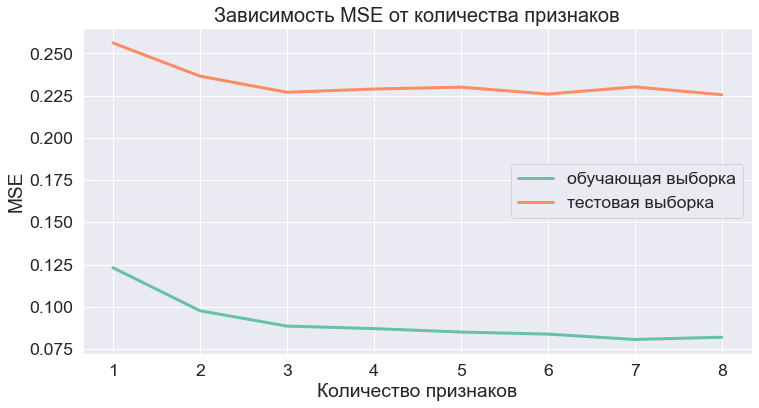

In [ ]:
plot_dependence(range(1, 9), mse_train_values, mse_test_values,
                'Количество признаков', 'MSE',
                'Зависимость MSE от количества признаков')

Чем больше значение `max_features`, тем меньше разнообразие деревьев. Когда `max_features` равно количеству признаков в датасете, градиентный бустинг перестаёт быть случайным. Как мы помним, при использовании случайного леса с некоторого значения `max_features` ошибка MSE начинала расти.

**2.**

Проведем сравнение градиентного бустинга и случайного леса с оптимальными гиперпараметрами, подобранными ранее, по производительности, в рамках которого выполним следующие действия.
* Замерим время обучения данных моделей.
* Замерим время построения предсказания для каждого объекта тестовой выборки. Построим гистограмму, посчитаем среднее время и предсказательный интервал.
* Сравним фактическую глубину деревьев и количество листьев в композициях с помощью гистограмм.

In [ ]:
model_gb = GradientBoostingRegressor(
    max_depth=max_depth, n_estimators=n_estimators,
    learning_rate=learning_rate, random_state=42
)
model_rf = RandomForestRegressor(
    n_estimators=226, max_depth=26, random_state=42, n_jobs=1
)
model_rf_max_n_jobs = RandomForestRegressor(
    n_estimators=226, max_depth=26, random_state=42, n_jobs=-1
)

models = {
    'gradient_boosting': model_gb,
    'random_forest': model_rf,
    'random_forest_max_n_jobs': model_rf_max_n_jobs
}

Замерим время обучения моделей.

In [ ]:
%%timeit
models['gradient_boosting'].fit(X_train, y_train)

11.2 s ± 353 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
models['random_forest'].fit(X_train, y_train)

15.3 s ± 178 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
%%timeit
models['random_forest_max_n_jobs'].fit(X_train, y_train)

1.79 s ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Видим, что случайный лес работает медленее без включения параллельности. В нем больше деревьев и они глубже. В режиме параллельности наблюдаем значительное ускорение вычислений.

Замерим время предсказания на каждом объекте тестовой выборки.

In [ ]:
models['gradient_boosting'].fit(X_train, y_train)
models['random_forest'].fit(X_train, y_train)
models['random_forest_max_n_jobs'].fit(X_train, y_train)

RandomForestRegressor(max_depth=26, n_estimators=226, n_jobs=-1,
                      random_state=42)

In [ ]:
times_models = defaultdict(list)
for i in tqdm(range(X_test.shape[0])):
    cur_x_test = X_test[i, np.newaxis]
    for key, model in models.items():
        start_time = time.perf_counter()
        model.predict(cur_x_test)
        times_models[key].append(time.perf_counter() - start_time)

  0%|          | 0/5160 [00:00<?, ?it/s]

Визуализируем гистограммы.

In [ ]:
def plot_comparative_hist(
    values_models, title, xlabel, label_formatting, plt_callback=None
):
    '''
    Функция для построения сравнительных гистограмм для разных моделей.

    Параметры.
    1) values_models - словарь с массивами значений для разных моделей,
    2) title - заголовки графиков,
    3) xlabel - обозначения для x-оси,
    4) label_formatting - тип форматирования для f-strings,
    5) plt_callback - коллбек-функция для уточнения графика.
    '''

    sns.set_style('whitegrid')
    plt.figure(figsize=(12, 12))
    for i, (key, values) in enumerate(values_models.items()):
        mean_value = np.mean(values)
        lower_quantile = np.quantile(values, q=0.025)
        upper_quantile = np.quantile(values, q=0.975)

        plt.subplot(3, 1, i+1)
        sns.histplot(values)
        plt.title(f'{title} для модели: {key}')
        plt.xlabel(xlabel)
        plt.xscale('log')
        plt.axvline(
            mean_value,
            label=f'mean={mean_value:{label_formatting}}',
            c='#FF3300'
        )
        plt.axvline(
            lower_quantile,
            label=f'$q_{{0.025}}$={lower_quantile:{label_formatting}}',
            c='orange'
        )
        plt.axvline(
            upper_quantile,
            label=f'$q_{{0.975}}$={upper_quantile:{label_formatting}}',
            c='orange'
        )
        plt.legend()
        if plt_callback is not None:
            plt_callback()

    plt.tight_layout()
    plt.show()
    sns.set_style('darkgrid')

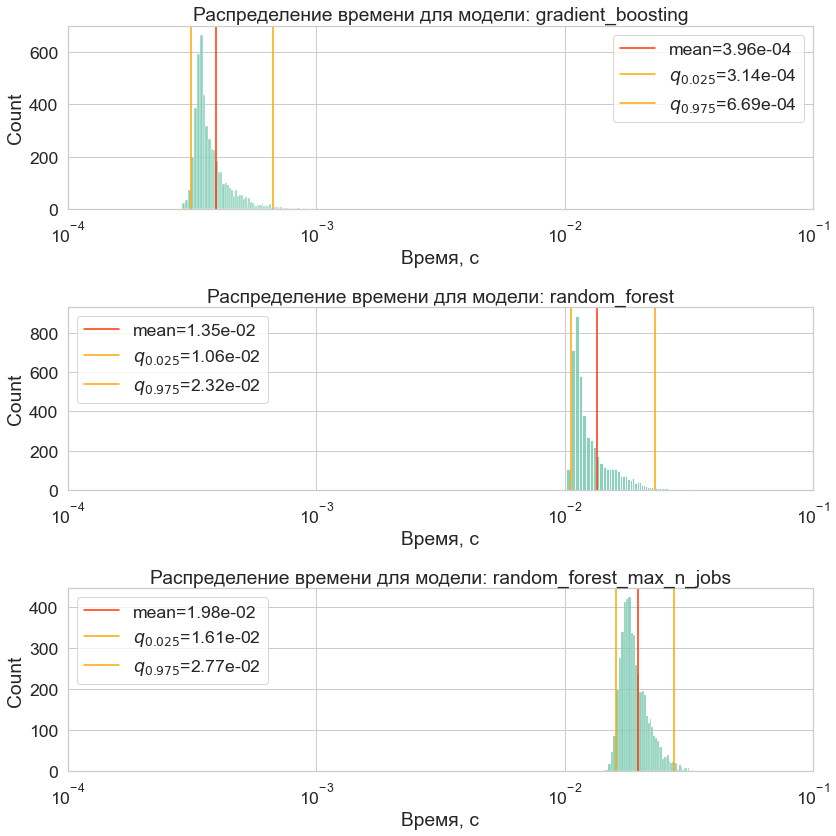

In [ ]:
plot_comparative_hist(
    values_models=times_models,
    title='Распределение времени',
    xlabel='Время, с',
    label_formatting='.2e',
    plt_callback=lambda: plt.xlim(1e-4, 1e-1)
)

Видим, что предсказание бустинга делается примерно в 30 раз быстрее. Время предсказания для случайного леса с `n_jobs=1` и `n_jobs=-1` практически не отличаются. Похоже, что на одном элементе не получается качественно запараллелить процесс предсказания.

Сравним фактическую глубину моделей.

In [ ]:
depths_models = defaultdict(list)
for key, model in models.items():
    for estimator in np.ravel(model.estimators_):
        depths_models[key].append(estimator.get_depth())

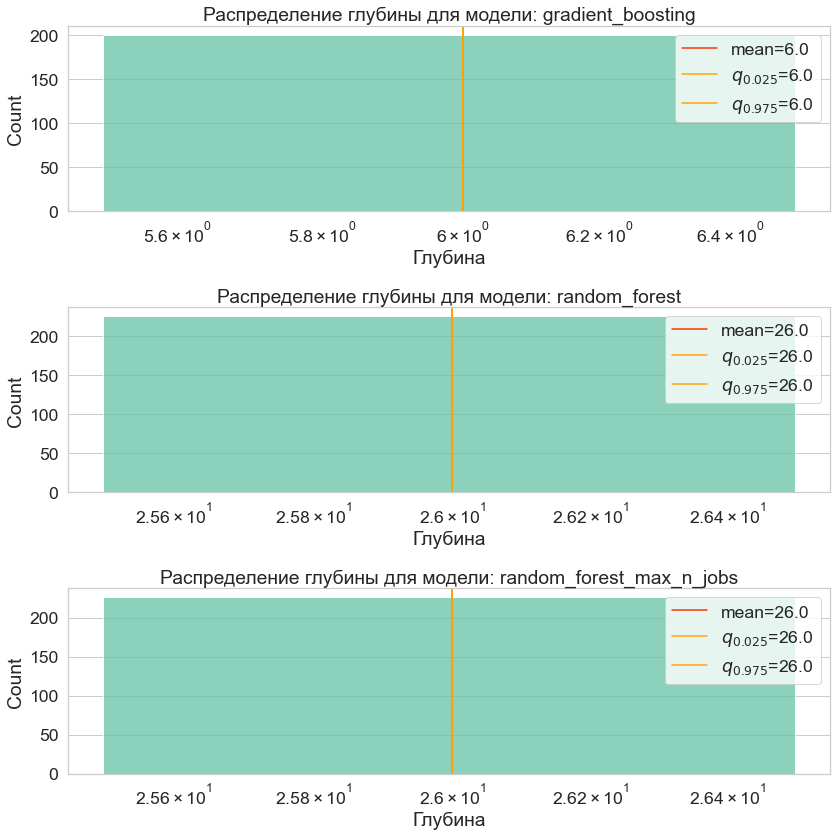

In [ ]:
plot_comparative_hist(
    values_models=depths_models,
    title='Распределение глубины',
    xlabel='Глубина',
    label_formatting="",
)

Видим вырожденные гистограммы, потому что везде глубина получилась ровно такая, какую указывали в `max_depth`.

Сравним количество листьев.

In [ ]:
n_leaves_models = defaultdict(list)
for key, model in models.items():
    for estimator in np.ravel(model.estimators_):
        n_leaves_models[key].append(estimator.get_n_leaves())

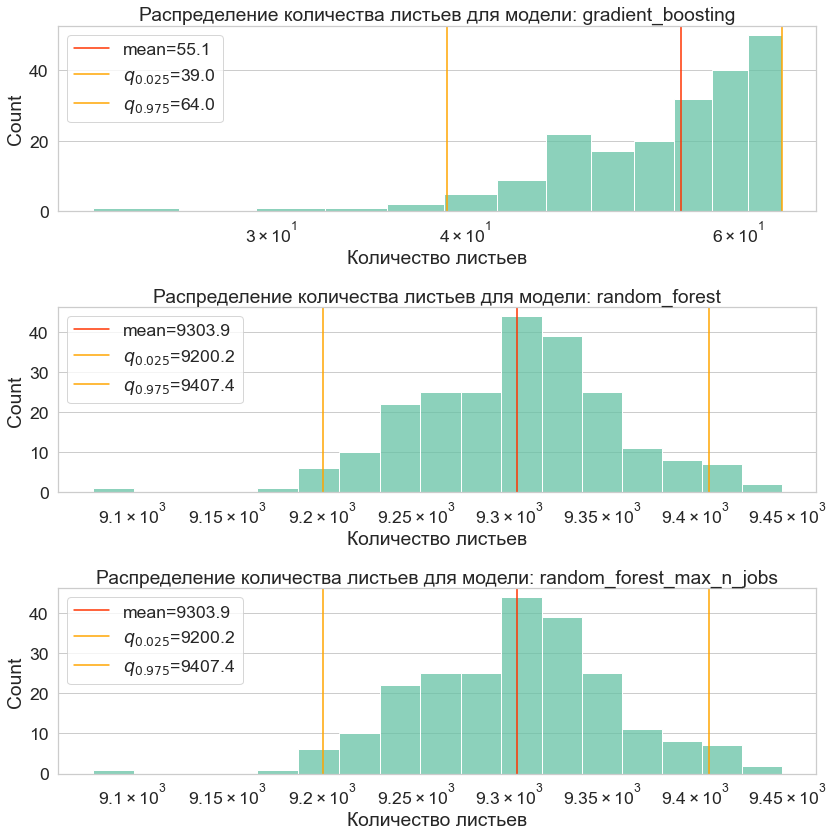

In [ ]:
plot_comparative_hist(
    values_models=n_leaves_models,
    title='Распределение количества листьев',
    xlabel='Количество листьев',
    label_formatting=".1f",
)

Видим, что у бустинга количество листьев имеет достаточно скошенное распределение и не превышает 64. Для случайного леса распределение более симметричное так как мы не упираемся в максимально возможное число листьев.

#### 3.

Выберим самый значимый признак согласно `feature_importances_`. Визуализируем работу бустинга, обученного только на одном этом признаке.

Для этого рассмотрите процесс построения бустинга для первых 10 итераций. При визуализации нужно для каждой итерации нарисовать:
* предсказания новой базовой модели и выборку, на которой эта базовая модель обучается;
* предсказания текущей композиции и исходную обучающую выборку.

Для определения наиболее значимого признака, обучим бустинг с оптимальными гиперпараметрами.

In [ ]:
gb_regressor = GradientBoostingRegressor(
    max_depth=max_depth, n_estimators=n_estimators,
    learning_rate=learning_rate, random_state=42
)

gb_regressor.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.10418060200668897, max_depth=6,
                          n_estimators=200, random_state=42)

Важности признаков

In [ ]:
for column, importance in zip(
    housing.feature_names, gb_regressor.feature_importances_
):
    print(f'{column}: {importance:.5f}')

MedInc: 0.53797
HouseAge: 0.04535
AveRooms: 0.03197
AveBedrms: 0.01467
Population: 0.01681
AveOccup: 0.13542
Latitude: 0.10758
Longitude: 0.11023


Первый признак (`MedInc`) оказался наиболее значимым.

Обучим градиентный бустинг для построения зависимости целевой переменной от `MedInc`.

In [ ]:
gb_regressor = GradientBoostingRegressor(n_estimators=10)
gb_regressor.fit(X_train[:, [0]], y_train)

GradientBoostingRegressor(n_estimators=10)

Визуализируем построенные деревья.

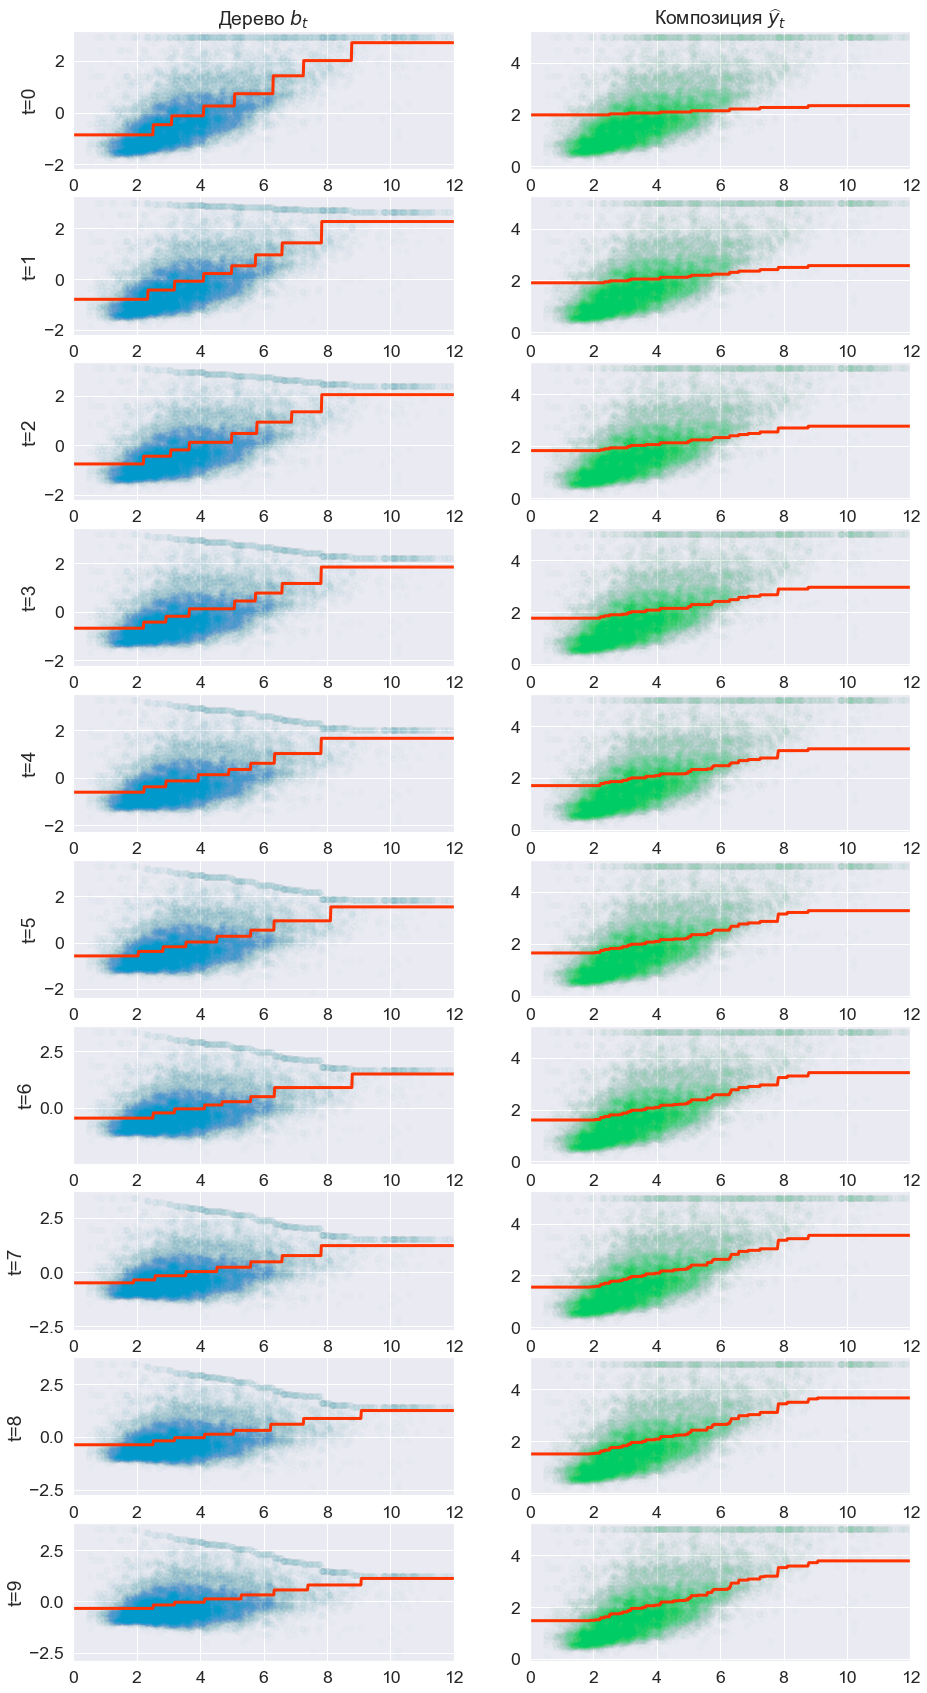

In [ ]:
grid = np.linspace(0, np.max(X_train[:, 0]), 1000)
staged_predicts = list(
    gb_regressor.staged_predict(grid.reshape((-1, 1)))
)
residuals = y_train.copy()

fig, ax = plt.subplots(10, 2, figsize=(15, 30))
for i in range(10):
    ax[i, 0].plot(
        grid, gb_regressor.estimators_[i, 0].predict(grid.reshape((-1, 1))),
        linewidth=3, color='#FF3300'
    )
    ax[i, 1].plot(grid, staged_predicts[i], linewidth=3, color='#FF3300')
    ax[i, 0].scatter(X_train[:, 0], residuals - y_train.mean(),
                     color='#0099CC', alpha=0.01)
    ax[i, 1].scatter(X_train[:, 0], y_train[:], color='#00CC66', alpha=0.01)
    ax[i, 0].set_ylabel(f't={i}')

    ax[i, 0].set_xlim((0, 12))
    ax[i, 1].set_xlim((0, 12))

    residuals -= (
        learning_rate
        * gb_regressor.estimators_[i, 0].predict(X_train[:, [0]])
    )

ax[0, 0].set_title('Дерево $b_t$')
ax[0, 1].set_title('Композиция $\\widehat{y}_t$')
plt.show()

**Вывод.**

По графику видно, что с возрастанием числа деревьев х композиция становится более гладкой и лучше приближает обучающую выборку.

#### 4.

Параметр `init` у класса `GradientBoostingRegressor` задает модель, выполняющую начальные предсказания, с которых стартует построение ансамбля. Какая начальная модель используется по умолчанию?

Согласно документации:

> By default a `DummyEstimator` is used, predicting either the average target value (for loss=’squared_error’), or a quantile for the other losses.

Это значит, что если мы при оптимизации используем квадратичный лосс, то в качестве начального приближения возьмется средний таргет.

Обучим градиентный бустинг на решающих деревьях, у которого в качестве инициализирующей модели используется линейная регрессия. Для этого в качестве параметра `init` передайте модель ридж-регрессии `Ridge`, которая должна быть инициализирована, но необучена.

Подберем оптимальные гиперпараметры такой композиции. Как будем подбирать гиперпараметр ридж-регрессии? Улучшилось ли качество модели на тестовой выборке?

Посмотрим на то, какие параметры есть у градиентного бустинга, который инициализируется с помощью линейной регрессии.

In [ ]:
ridge_pipeline = Pipeline([('scaler', StandardScaler()), ('ridge', Ridge())])
gb_ridge_regressor = GradientBoostingRegressor(
    n_estimators=n_estimators, init=ridge_pipeline, random_state=42
)
print(gb_ridge_regressor.get_params())

{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': 'friedman_mse', 'init__memory': None, 'init__steps': [('scaler', StandardScaler()), ('ridge', Ridge())], 'init__verbose': False, 'init__scaler': StandardScaler(), 'init__ridge': Ridge(), 'init__scaler__copy': True, 'init__scaler__with_mean': True, 'init__scaler__with_std': True, 'init__ridge__alpha': 1.0, 'init__ridge__copy_X': True, 'init__ridge__fit_intercept': True, 'init__ridge__max_iter': None, 'init__ridge__normalize': 'deprecated', 'init__ridge__positive': False, 'init__ridge__random_state': None, 'init__ridge__solver': 'auto', 'init__ridge__tol': 0.001, 'init': Pipeline(steps=[('scaler', StandardScaler()), ('ridge', Ridge())]), 'learning_rate': 0.1, 'loss': 'squared_error', 'max_depth': 3, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 200, 'n_iter_no_change': None, 'random_state': 42, 'subsample': 1.0, 'tol':

К параметру `alpha` Ridge-регрессии нужно обращаться через имя `init__alpha`. Не путать с `alpha`, являющимся гиперпараметром самого градиентого бустинга!

In [ ]:
gb_ridge_gridsearch = RandomizedSearchCV(
    estimator=gb_ridge_regressor,
    param_distributions={
        'max_depth': np.arange(3, 20),
        'learning_rate': np.linspace(0.05, 0.5, 300),
        'init__ridge__alpha': np.logspace(-3, 3, 501)
    },
    cv=5,  # разбиение выборки на 5 фолдов
    verbose=1,  # насколько часто печатать сообщения
    n_jobs=-2,  # кол-во параллельных процессов
    n_iter=50,  # кол-во итераций случайного выбора гиперпараметров
    random_state=3,  # seed для фиксирования случайности
)

Выполним поиск параметров:

In [ ]:
gb_ridge_gridsearch.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=GradientBoostingRegressor(init=Pipeline(steps=[('scaler',
                                                                             StandardScaler()),
                                                                            ('ridge',
                                                                             Ridge())]),
                                                       n_estimators=200,
                                                       random_state=42),
                   n_iter=50, n_jobs=-2,
                   param_distributions={'init__ridge__alpha': array([1.00000000e-03, 1.02801630e-03, 1.05681751e-03, 1.08642562e-03,
       1.11686325e-03, 1.14815362e-03, 1.18032064e-03, 1.21338885e-0...
       0.4638796 , 0.46538462, 0.46688963, 0.46839465, 0.46989967,
       0.47140468, 0.4729097 , 0.47441472, 0.47591973, 0.47742475,
       0.47892977, 0.48043478, 0.4819398 , 0.48344482, 0.48494983,
       0.48645485, 0.487

Оптимальные значения гиперпараметров

In [ ]:
print(gb_ridge_gridsearch.best_params_)

{'max_depth': 6, 'learning_rate': 0.14481605351170568, 'init__ridge__alpha': 0.003019951720402016}


Оптимальное качество по MSE:

In [ ]:
mse_test = mse(y_true=y_test, y_pred=gb_ridge_gridsearch.predict(X_test))
print(f'MSE = {mse_test:.5f}')

MSE = 0.22845


**Вывод.**

В данном случае не удалось улучшить качество, взяв другую модель в качестве инициализирующей. Иногда это может быть полезно и можно получить дополнительный небольшой прирост качества. Однако, такой подход используется довольно редко, так как обычно достаточно взять инициализирующую модель, предсказывающую среднее значение таргета или ноль для всех объектов.

#### 5.

Рассмотрим модели смеси градиентного бустинга $\widehat{y}_{gb}$ и случайного леса $\widehat{y}_{rf}$ с оптимальными гиперпараметрами, подобранными ранее, в виде
$$\widehat{y}(x) = w \widehat{y}_{gb}(x) +  (1-w) \widehat{y}_{rf}(x),$$
где $w \in [0, 1]$ &mdash; коэффициент усреднения. Подберите оптимальное значение гиперпараметра $w$ и выведите его. Удалось ли добиться улучшения качества на тестовой выборке?

Обучим модели градиентного бустинга с подобранными ранее гиперпараметрами и случайного леса.

In [ ]:
model_gb = GradientBoostingRegressor(
    max_depth=max_depth, n_estimators=n_estimators,
    learning_rate=learning_rate, random_state=42
)
model_rf = RandomForestRegressor(
    n_estimators=226, max_depth=26, random_state=42
)

Подберем оптимальный вес для смеси моделей при помощи out-of-fold валидации.

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
preds_gb = cross_val_predict(model_gb, X_train, y_train, cv=10)
preds_rf = cross_val_predict(model_rf, X_train, y_train, cv=10)

In [ ]:
mse_values = []
w_values = np.linspace(0, 1, 101)

for w in w_values:
    predictions = w * preds_gb + (1 - w) * preds_rf
    mse_values.append(mse(y_true=y_train, y_pred=predictions))

Построим график зависимости MSE от коэффициента смеси `w`.

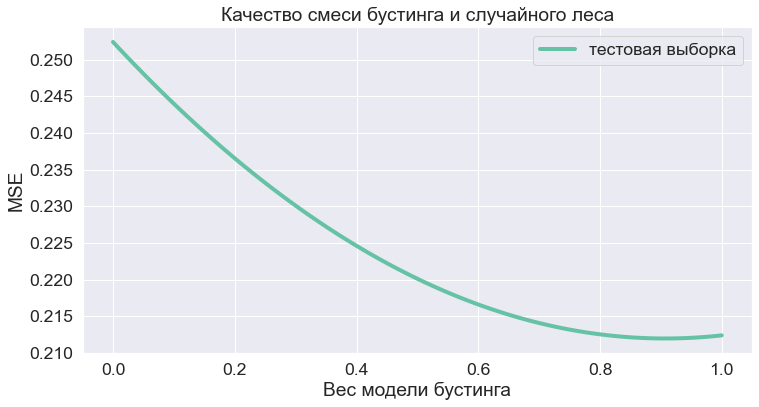

In [ ]:
plot_dependence_test(np.linspace(0.0, 1.0, 101), mse_values,
                'Вес модели бустинга', 'MSE',
                'Качество смеси бустинга и случайного леса')

Выведем лучшее значение коэффициента усреднения:

In [ ]:
best_w = w_values[np.argmin(mse_values)]
print(f'Лучшее значение коэффициента усреднения: {best_w:.3f}')

Лучшее значение коэффициента усреднения: 0.910


Посчитаем качество на тесте с этим коэффициентом.

In [ ]:
model_gb.fit(X_train, y_train)
model_rf.fit(X_train, y_train)

preds_gb = model_gb.predict(X_test)
preds_rf = model_rf.predict(X_test)

predictions = w * preds_gb + (1 - w) * preds_rf
mse_test = mse(y_true=y_test, y_pred=predictions)
print(f'MSE на тесте: {mse_test:.5f}')

MSE на тесте: 0.22556


Использование смеси градиентного бустинга и случайного леса со значением $w = 0.91$ дает такой же результат, как лучшая модель градиентного бустинга без инициализации.

Это связано с тем, что предсказания градиентного бустинга и случайного леса для данной задачи достаточно сильно коррелируют. Вообще, взвешенное усреднение является популярным методом построения композиций, для этого желательно выбирать сильно различающиеся модели.